# Imbalanced Data Binary Classification

<a id="0"></a> <br>

 # Table of Contents  
- [Imports](#2)
- [Import Data](#3)
- [Check and Join Data](#4)
- [Clean the Data](#5)
- [Exploratory Data Anlysis](#6)
    - [Type Analysis](#7)
    - [Numerical Data Analysis](#8)
- [Models](#9)
    - [PreProcessing](#10)
    - [Training](#11)
    - [Over Sampling](#12)
    - [Under Sampling](#13)
    - [Dimensionality Reduction](#14)
        - [PCA](#15)
        - [Kernel PCA](16)
- [Model Evaluation](#17)
    - [Metrics](#18)
- [Conclusion](#19)

<a id="2"></a>

## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from scipy import stats
from scipy.stats import skew
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.pipeline import Pipeline
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

<a id="3"></a>

## Import Data 

In [2]:
df_1 = pd.read_csv("/home/tom/3rd_Year/data_1.csv", sep=';')
df_2 = pd.read_csv("/home/tom/3rd_Year/data_2.csv", sep=';')

There are unique identifiers (the "ID" columns) in each dataset. I will join the two dataframes on this identifier. First however, I need to check no rows have been duplicated. 

<a id="4"></a>


### Check and Join Data

In [3]:
df_1.ID.value_counts()

ID
3553    4
118     4
3583    3
771     3
352     3
       ..
1297    1
1298    1
1299    1
1300    1
3699    1
Name: count, Length: 3700, dtype: int64

In [4]:
df_2.ID.value_counts()

ID
1969    4
305     4
3190    3
2189    3
2608    3
       ..
1296    1
1297    1
1298    1
1299    1
3699    1
Name: count, Length: 3700, dtype: int64

As the "ID" column represents a unique identifier for each row, having multiple counts of the IDs means I have duplicates in the data which need to be removed before joining.

In [5]:
df_1 = df_1.drop_duplicates()

In [6]:
df_2 = df_2.drop_duplicates()

In [7]:
df = df_1.merge(df_2, on = 'ID', how = 'left')

Since the data is small (3700 rows) and the ID is unique to each row in each dataset, I could use any join (inner, left, right, outer). I chose a left join because it is more efficient than an inner join but due to our data's size, this is not really a concern here. 

<a id="5"></a>

## Clean the Data

Now I've merged the data, I need to drop the ID column.

In [8]:
# get rid of ID
df = df.drop(columns = ['ID'])

I need to check for null values in our data.

In [9]:
df.isnull().sum(axis = 0)

UKL         0
GJAH       64
ZIK      2145
HUI         0
ERZ        64
CDx         0
BJZHD      66
NKJUD     100
LPI       100
BJKG       66
POUG        0
TRE         0
ZUB         0
VOL         0
UIO        39
VBNM        0
Type        0
OIN        39
dtype: int64

Interestingly, we see the ZIK has a very high number of null values (roughly 58% of the column). Removing these would reduce our data size too much and since ZIK is categorical data, I will use the null values in the ZIK column as their own category.

For the rest of the categorical data, given the number of null values is small for each column, I will remove these from the dataset.

The numerical data does not contain too many null values and so I will replace these by the mean of that column. 

It's worth noting that UKL and POUG are categorical data despite being respresented as integers (indicated by not having a decimal point).

In [10]:
# function to convert null values to a category "NaN" in the ZIK column

def convert_zik_nan_to_label(x):
    if pd.isnull(x) == True:
        return "NaN"
    else:
        return x

In [11]:
df.ZIK = df.ZIK.apply(convert_zik_nan_to_label)  # convert null values in the ZIK columns to categories

In [12]:
# create lists for the column names of numerical and categorical data respectively

num_data = ['CDx', 'NKJUD', 'LPI', 'TRE', 'OIN']

cat_data = [i for i in df.columns if i not in num_data]

In [13]:
# replace the null values in the numerical data columns by the mean of that column

df[num_data] = df[num_data].fillna(df[num_data].mean())

In [14]:
# the remaining null values come from categorical data whichI decided to remove

df = df.dropna()

In [15]:
# to ensure the data is high quality, I will remove any outliers. I have taken an outlier to be a datapoint that is 
# outside of 3 standard deviations from the column's mean.

df[num_data] = df[num_data][(np.abs(stats.zscore(df[num_data])) < 3).all(axis=1)]
df = df.dropna()

<a id="6"></a>


## Exploratory Data Analysis 

<a id="7"></a>

## Type Analysis

Before exploring different models, I would like to explore quickly the labels.

In [16]:
df.Type.value_counts()

Type
y    3168
n     263
Name: count, dtype: int64

In [17]:
df.Type.value_counts()['y'] / df.Type.value_counts().sum()

0.9233459632760128

I can see here that I have an imbalanced datatset with roughly 92% of data being "y" and only 8% being "n". This will change how I procede with the models.

<a id="8"></a>


## Numerical Data Analysis

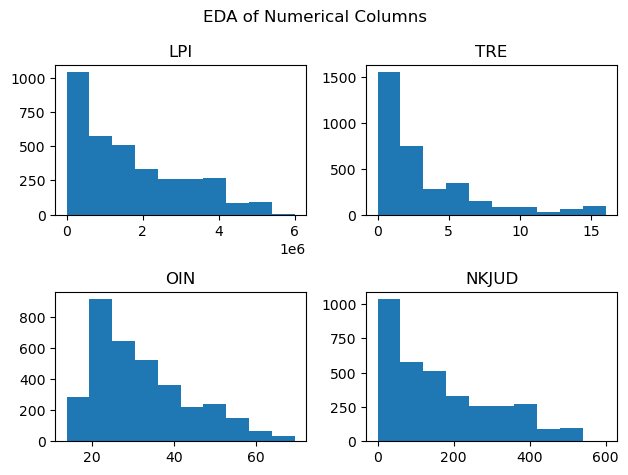

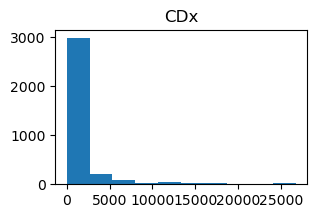

In [18]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('EDA of Numerical Columns')
ax1.hist(df.LPI)
ax1.set_title('LPI')

ax2.hist(df.TRE)
ax2.set_title('TRE')

ax3.hist(df.OIN)
ax3.set_title('OIN')

ax4.hist(df.NKJUD)
ax4.set_title('NKJUD')

fig.tight_layout()
plt.show()


fig = plt.figure(figsize=(3.25, 2))
plt.hist(df.CDx)
plt.title("CDx")
plt.show()

It's worth noting here that all numerical data displays positive skew.

In [19]:
for col in num_data:
    print(col, " skew: ", skew(df[col]))


CDx  skew:  4.40161195549708
NKJUD  skew:  0.6670649286820493
LPI  skew:  0.6670649286820493
TRE  skew:  1.7208012630708451
OIN  skew:  0.8689058781206994


As expected from the graphs, all categories show positive skew with CDx being the most skewed and LPI and NKLUD the least.

This is important because it informs me that I need to use MinMax Normalisation rather than standard scalarisation. Standard scaling works best with normally distributed data and applying standard scaling to this data might result in sub-optimal performance. MinMax scaling, however, preserves the shape of the data and so will be used here.  

<a id="9"></a>

# Models

I now separate the gold classes from the rest of the data and split into 80% for training data and 20% for test data.

In [20]:
X = df.drop(columns = ['Type'])
y = df.Type

cat_data.remove("Type")  # remove Type from the categorical data as we don't want it in one hot encoding

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)

<a id="10"></a>

## Preprocessing

Before feeding the data into the models, I need to preprocess it.

In [22]:
print("LPI Mean: ", df.LPI.mean())
print("TRE Mean: ", df.TRE.mean())

LPI Mean:  1580431.4194112504
TRE Mean:  3.2148615563975516


Firstly, there is a large range in values for the numerical data. The "LPI" column, for example, has a mean of 15 80 431.5 whilst the "TRE" column has a mean of 3.2. This wide range of numerical values will lead to poor model performance and so I will normalise each column using MinMax scaling. MinMax preserves the shape of the data whilst also transforming it to between 0 and 1. Note the MinMaxScaler class is not fitted on the test data, only the training data, this prevents leakage into the test dataset that would impact results.

In [23]:
minmax_train = MinMaxScaler()

minmax_train.fit(X[num_data])

X_train[num_data] = minmax_train.transform(X_train[num_data])
X_test[num_data] = minmax_train.transform(X_test[num_data])

The categorical data needs to be converted to numerical data before being fed into my models. To do this, I will use One Hot Encoding (OHE). For an indivdual column, this creates an array of 0's with the number of columns the same as the number of unique categories of that column. For each row (or datapoint), a 1 is placed in the column corresponding to the category of that datapoint. This is repeated for each column, creating a high dimensional sparse matrix which can be fed into the models. Note, as with the MinMaxScaler, the OneHotEncoder class is not fitted on the test data, only the training data.

In [24]:
ohe_train = OneHotEncoder(handle_unknown = 'ignore')

ohe_train.fit(X_train[cat_data])

ohe_array_train = ohe_train.transform(X_train[cat_data])

X_ohe_train = pd.DataFrame(ohe_array_train.toarray(), index = X_train.index)

X_other_cols_train = X_train.drop(columns=cat_data)

X_train = pd.concat([X_other_cols_train, X_ohe_train], axis=1)

X_train.columns = X_train.columns.astype(str)

In [25]:
ohe_array_test = ohe_train.transform(X_test[cat_data])

X_ohe_test = pd.DataFrame(ohe_array_test.toarray(), index = X_test.index)

X_other_cols_test = X_test.drop(columns=cat_data)

X_test = pd.concat([X_other_cols_test, X_ohe_test], axis=1)

X_test.columns = X_test.columns.astype(str)

To better process the Type values, I will convert these to a binary representation: 1 - y, 0 - n

In [26]:
label_encode_train = LabelEncoder()

label_encode_train.fit(y_train)

y_train = label_encode_train.transform(y_train)
y_test = label_encode_train.transform(y_test)

<a id="11"></a>

## Training

Below are two functions that perform 5-fold cross validation on the train set, tuning the huperparameters on the F1 macro score (discussed above). The "model_evaluation" function outputs a dictionary containing, for each Logistic Regression, XGBoost Classifier and DecisionTree Classifier, the parameters making up the best model and the predictions from that model. 

In [27]:
def cross_validate_model(model, parameters, X_train, y_train, X_test):
        
    # set up the cross validation for the specified model
    
    grid_search = GridSearchCV(estimator = model,  
                           param_grid = parameters,
                           scoring = 'f1_macro',
                           cv = 5,
                           verbose=0)
    
    # fit this grid search 
    
    grid_search.fit(X_train, y_train)
    
    # define and train the best model from the grid_search
    
    best_model = grid_search.best_estimator_
    best_model.fit(X_train, y_train)
    
    # get the best predictions from the best model
    
    
    y_pred  = best_model.predict(X_test)
    
    
    return grid_search.best_params_, y_pred
    

In [28]:
def model_evaluation(X_train, y_train, X_test):
    
    # This is a function that performs cross validation hyperparameter tuning on a 
    # Logistic Regression Model, XGBoost Classifier and Decision Tree Model. 
    # I take the best hyparameters from each model that maximises the f1_macro score.
    # I output these parameters as well as the corresponding models predictions in a dictionary
    
    output_dictionary = {}
    
    best_model_dict = {}
    
    best_predictions_dict = {}
        
    
    # Logistic Regression
    
    # define parameters to test
    
    log_reg_parameters = [
      {'penalty': ['l1'], 'C':[0.01,1,5,10], 'class_weight': ['balanced', None], 'solver': [ 'liblinear']},
      {'penalty': ['l2'], 'C':[0.01,1,5,10], 'class_weight': ['balanced', None], 'solver': ['lbfgs', 'liblinear']},
      {'penalty': [None], 'solver': ['lbfgs']}
     ]
    
    # max number of iterations set high so that all the models converge
    # lbfgs sometimes resulted in non-convergence in the default 100 iterations
    
    log_reg_model = LogisticRegression(max_iter = 5000)
    
    best_params_log_reg, y_pred_log_reg = cross_validate_model(log_reg_model, log_reg_parameters,
                                                                X_train, y_train, 
                                                               X_test)
    
    best_model_dict['log_reg'] = best_params_log_reg
    best_predictions_dict['log_reg'] = y_pred_log_reg
    
    
    # XGBoost Classifier
    
    # define XGBoost parameters
    
    xgb_parameters = [
        {'max_depth': [5, 10, 25, 50, 100],
        'learning_rate': [1, 0.1, 0.01],
        'scale_pos_weight': [1, 50, 100]
        }
    ]


    best_params_xgb, y_pred_xgb = cross_validate_model(XGBClassifier(), xgb_parameters,
                                                                                X_train, y_train,
                                                                                X_test)
    best_model_dict['xgb'] = best_params_xgb
    best_predictions_dict['xgb'] = y_pred_xgb
    
    # Decision Tree
    
    #define decision tree parameters
    
    dec_tree_parameters = [
        { 'criterion': ['gini', 'entropy'],
        'max_depth': [None, 2, 4, 6, 8, 10, 12],
          'class_weight': ['balanced', None] 
        }
    ]
    
    dec_tree = DecisionTreeClassifier()
    
    best_params_dec_tree, y_pred_dec_tree = cross_validate_model(dec_tree, dec_tree_parameters,
                                                                                X_train, y_train,
                                                                                X_test)
    best_model_dict['dec_tree'] = best_params_dec_tree
    best_predictions_dict['dec_tree'] = y_pred_dec_tree
    
    output_dictionary['best_model'] = best_model_dict
    output_dictionary['best_predictions'] = best_predictions_dict
    
    return output_dictionary     

In [29]:
# run the model evaluation on the dataset given for the task

original_data_dict = model_evaluation(X_train, y_train, X_test)

<a id="12"></a>

## Over Sampling

In [30]:
# over sample the data (randomly generating similar datapoints to the minority class)

oversample = RandomOverSampler(sampling_strategy=0.5)
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)

In [31]:
# evaluating the models on this new data

over_sampled_data_dict = model_evaluation(X_train_over, y_train_over, X_test)

<a id="13"></a>


## Under Sampling

In [34]:
# under sample the data (randomly deleting data points from the minority class)

undersample = RandomUnderSampler(sampling_strategy=0.5)
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)

In [40]:
under_sampled_data_dict = model_evaluation(X_train_under, y_train_under, X_test)

<a id="14"></a>


## Dimensionality Reduction

One hot encoding our data results in high dimensional sparse data which is not always the best for machine learning models. One method to combat this, is to reduce the dimension size of the data through various methods. Here I explore a linear method (PCA reduction) as well as discussing a non-linear one (Kernel PCA). The reduction hyperparameters are tuned in conjuction with the hyperparameters of the models.

In [33]:
def cross_validate_model_dim_red(model, model_parameters, X_train, y_train, X_test, reduction, reduction_params):
    
    # define the pipeline to tune: first reduce the dimension size, then perform the classification
    
    pipeline = Pipeline([
         (type(reduction).__name__, reduction),
         (type(model).__name__ , model)
         ])
        
    # the parameter names in a parameter grid for a pipeline require a specific title
    # for a proces, p (which could be reduction or model in our case), parameters
    # are named p__parameter. The parameters for each of the models and
    # for the reduction have to be named in this convetion (code below) and are then
    # combined into one parameter grid
    
    combined_params = []

    for model_param in model_parameters:

        combined_param = {}

        for key, value in model_param.items():
            combined_param[type(model).__name__ + "__" + key] = value

        for red_param_key, red_param_value in reduction_params[0].items():
            combined_param[type(reduction).__name__ + "__" + red_param_key] = red_param_value

        combined_params.append(combined_param)
        
    # feed pipeline and combined parameter grid into the cross validation grid search
    
    grid_search = GridSearchCV(estimator = pipeline,  
                           param_grid = combined_params,
                           scoring = 'f1_macro',
                           cv = 5,
                           verbose=0)
    # fit the grid search    
    
    grid_search.fit(X_train, y_train)
    
    # define and train the best model
    
    best_model = grid_search.best_estimator_
    best_model.fit(X_train, y_train)
    
    # get the best predictions from this model 
    
    y_pred  = best_model.predict(X_test)
    
    
    return grid_search.best_params_, y_pred
    

In [35]:
def dim_reduced_model_evaluation(reduction, reduction_params, X_train, y_train, X_test):
   
    # This is a function that performs cross validation hyperparameter tuning on a 
    # dimenionsality reduction then Logistic Regression Model, XGBoost Classifier or Decision Tree Model. 
    # I take the best hyparameters from each reduction-model combination that maximises the f1_macro score.
    # I output these parameters as well as the corresponding models predictions in a dictionary
    
    # very similar procedure to the non dimenionally reduced cross validation
    
    output_dictionary = {}
    
    best_model_dict = {}
    
    best_predictions_dict = {}
            
    # Logistic Regression
    
    log_reg_parameters = [
      {'penalty': ['l1'], 'C':[0.01,1,5,10], 'class_weight': ['balanced', None], 'solver': [ 'liblinear']},
      {'penalty': ['l2'], 'C':[0.01,1,5,10], 'class_weight': ['balanced', None], 'solver': ['lbfgs', 'liblinear']},
      {'penalty': [None], 'solver': ['lbfgs']}
     ]
    
    log_reg_model = LogisticRegression(max_iter = 5000)
    
    best_params_log_reg, y_pred_log_reg = cross_validate_model_dim_red(log_reg_model, log_reg_parameters,
                                                                                                X_train, y_train, 
                                                                                                X_test, 
                                                                                               reduction, reduction_params)
    best_model_dict['log_reg'] = best_params_log_reg
    best_predictions_dict['log_reg'] = y_pred_log_reg
    
    
    # XGBoost Classifier
    
    xgb_parameters = [
        {'max_depth': [5, 10, 25, 50, 100],
        'learning_rate': [1, 0.1, 0.01],
        'scale_pos_weight': [1, 50, 100]
        }
    ]


    best_params_xgb, y_pred_xgb = cross_validate_model_dim_red(XGBClassifier(), xgb_parameters,
                                                                                X_train, y_train,
                                                                                X_test,
                                                                               reduction, reduction_params)
    best_model_dict['xgb'] = best_params_xgb
    best_predictions_dict['xgb'] = y_pred_xgb
    
    # Decision Tree
    
    dec_tree_parameters = [
        { 'criterion': ['gini', 'entropy'],
        'max_depth': [None, 2, 4, 6, 8, 10, 12],
          'class_weight': ['balanced', None] 
        }
    ]
    
    dec_tree = DecisionTreeClassifier()
    
    best_params_dec_tree, y_pred_dec_tree = cross_validate_model_dim_red(dec_tree, dec_tree_parameters,
                                                                                X_train, y_train,
                                                                                X_test, 
                                                                                reduction, reduction_params)
    best_model_dict['dec_tree'] = best_params_dec_tree
    best_predictions_dict['dec_tree'] = y_pred_dec_tree
    
    output_dictionary['best_model'] = best_model_dict
    output_dictionary['best_predictions'] = best_predictions_dict
    
    return output_dictionary     
    

<a id="15"></a>

## PCA

PCA reduction is a common linear reduction technique based on sinular value decomposition. New embeddings (known as Principal Components) are often thought of as linear combinations of the original features (hence being called a linear reduction). PCA also results in a "variance" score for each of the principal components which can be interpreted as that component's ability to explain the whole data set. Using these scores, we can determine the optimal number of components we need (a number high enough that enough of the data is encoded). 

In [36]:
pca_test = PCA(n_components=15)
pca_test.fit(X_train)

explained_variance = pd.DataFrame(pca_test.explained_variance_ratio_)
print("Explained Variance for Number of Dimensions: ")
print(explained_variance)

print("\nSum of variance for first 15 dimensions: ")
print(explained_variance[:15].sum()[0])

Explained Variance for Number of Dimensions: 
           0
0   0.149381
1   0.096150
2   0.076152
3   0.066494
4   0.063273
5   0.059007
6   0.033810
7   0.030235
8   0.026563
9   0.024540
10  0.020763
11  0.019174
12  0.017682
13  0.016588
14  0.014291

Sum of variance for first 15 dimensions: 
0.7141031640215998


Above I have conducted a quick test to see how well PCA performs on this data. Unfortunately, the first 15 dimensions only equate to an explained variance of 0.71 (out of 1). Whilst this is OK, it is not ideal - one would ideally prefer an explained variance in the 0.9s. This suggests the data is not linear and so this technique will likely not improve the results. That said, it will be interesting to see if this is the case.

In [39]:
pca = PCA()

param_grid_pca = [{
 "n_components": [10, 15, 30, 50]
 }]

pca_data_dict = dim_reduced_model_evaluation(pca, param_grid_pca, X_train, y_train, X_test)

<a id="16"></a>

## Kernel PCA

Based off the test PCA, it appears a non-linear reduction technique might be better suited for this data. In order to directly compare with the PCA results, I have chosen to use Kernel PCA, exploring both polynomial and rbf kernel functions.

In [38]:

kpca = KernelPCA()


param_grid_kpca = [{
    "n_components": [10, 15],
    "kernel": ['poly', 'rbf']
}]


kpca_data_dict = dim_reduced_model_evaluation(kpca, param_grid_kpca, X_train, y_train, X_test)



<a id="17"></a>

## Model Evaluation


In [41]:
dict_lists = {
    'original': original_data_dict, 
    'over': over_sampled_data_dict, 
    'under': under_sampled_data_dict, 
    'pca': pca_data_dict, 
    'kpca': kpca_data_dict
}

models = ['LogisticRegression', 'XGBoost', 'DecisionTree']


In [42]:
f_1_score = {}

for data_type, data in dict_lists.items():
    
    data_type_score = []
    
    for model, y_pred in data['best_predictions'].items():
    
        data_type_score.append(f1_score(y_test, y_pred, average='macro'))
    f_1_score[data_type] = data_type_score



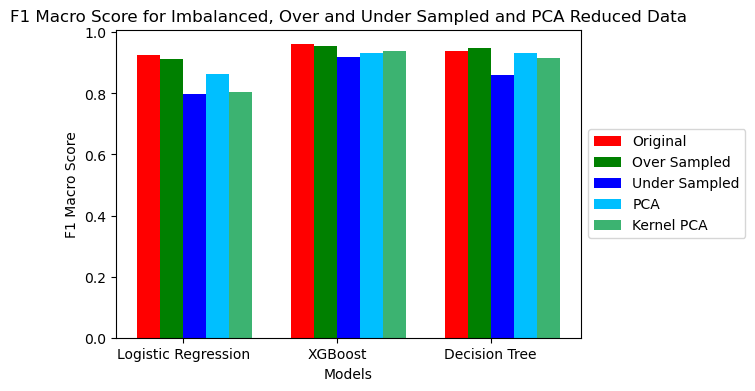

In [43]:
N = 3
ind = np.arange(N)  
width = 0.15

plt.figure(figsize=(6,4))
bar1 = plt.bar(ind, f_1_score['original'], width, color='r', label='Original') 
bar2 = plt.bar(ind + width, f_1_score['over'], width, color='g', label='Over Sampled') 
bar3 = plt.bar(ind + width*2, f_1_score['under'], width, color='b', label='Under Sampled')
bar4 = plt.bar(ind + width*3, f_1_score['pca'], width, color='deepskyblue', label='PCA') 
bar5 = plt.bar(ind + width*4, f_1_score['kpca'], width, color='mediumseagreen', label='Kernel PCA') 

plt.xlabel("Models") 
plt.ylabel('F1 Macro Score') 
plt.title("F1 Macro Score for Imbalanced, Over and Under Sampled and PCA Reduced Data") 
  
plt.xticks(ind + width*1.5, ['Logistic Regression', 'XGBoost', 'Decision Tree']) 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.show() 

There are some interesting results here. Firstly, we see that pretty much all methods don't perform as well as just using the original data. This would make sense for the sampling techniques, especially under sampling that removes a significant proportion of the data. What is particularly interesting here is the performance of PCA reduction which considerably outperforms the non-linear technique in Logisitic Regression and the Decision Tree models. This is contrary to my initial hypothesis based on the explained variances. I also see that oversampling outperforms no sampling in Decision tree models. In all, the XGBoost model trained on the original data resulted in the best model. 

In [44]:
roc_auc = {}

for data_type, data in dict_lists.items():
    
    data_type_score = []
    
    for model, y_pred in data['best_predictions'].items():
    
        data_type_score.append(roc_auc_score(y_test, y_pred))
    roc_auc[data_type] = data_type_score

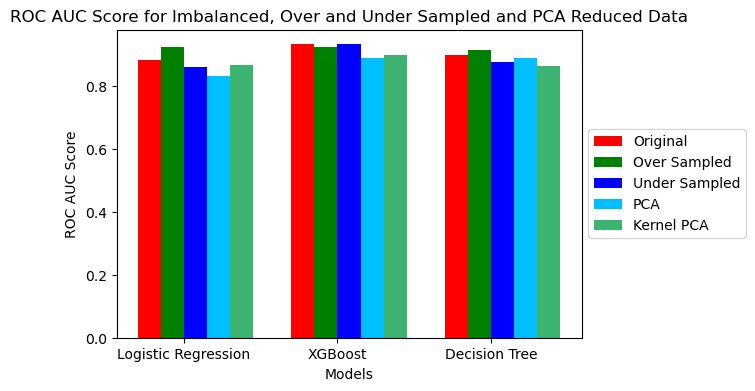

In [45]:
N = 3
ind = np.arange(N)  
width = 0.15

plt.figure(figsize=(6,4))
bar1 = plt.bar(ind, roc_auc['original'], width, color='r', label='Original') 
bar2 = plt.bar(ind + width, roc_auc['over'], width, color='g', label='Over Sampled') 
bar3 = plt.bar(ind + width*2, roc_auc['under'], width, color='b', label='Under Sampled')
bar4 = plt.bar(ind + width*3, roc_auc['pca'], width, color='deepskyblue', label='PCA') 
bar5 = plt.bar(ind + width*4, roc_auc['kpca'], width, color='mediumseagreen', label='Kernel PCA') 


plt.xlabel("Models") 
plt.ylabel('ROC AUC Score') 
plt.title("ROC AUC Score for Imbalanced, Over and Under Sampled and PCA Reduced Data") 
  
plt.xticks(ind + width*1.5, ['Logistic Regression', 'XGBoost', 'Decision Tree']) 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.show() 

The first striking result from this graph is the increased ROC AUC score for the over sampled Logistic model. Additionally, we see that under sampling results in a better score than original for XGBoost which is impressive considering this technique's significant reduction in the size of data. This could perhaps be useful when data collection is difficult or expensive.  

In [46]:
accuracy = {}

for data_type, data in dict_lists.items():
    
    data_type_score = []
    
    for model, y_pred in data['best_predictions'].items():
    
        data_type_score.append(accuracy_score(y_test, y_pred))
    accuracy[data_type] = data_type_score

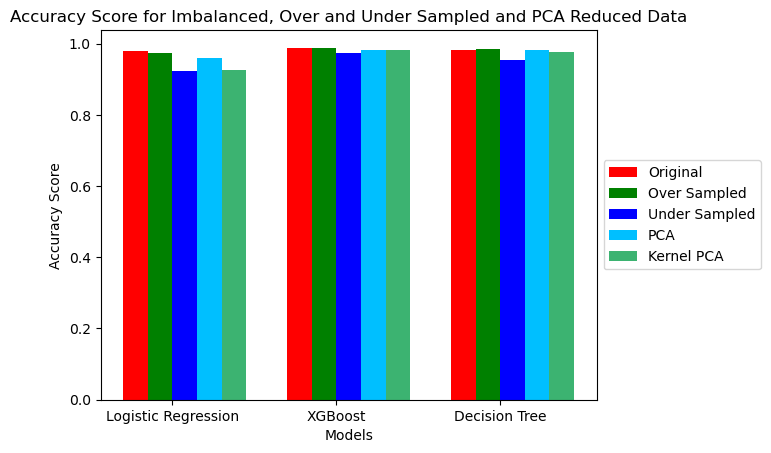

In [47]:
N = 3
ind = np.arange(N)  
width = 0.15
  
bar1 = plt.bar(ind, accuracy['original'], width, color='r', label='Original') 
bar2 = plt.bar(ind + width, accuracy['over'], width, color='g', label='Over Sampled') 
bar3 = plt.bar(ind + width*2, accuracy['under'], width, color='b', label='Under Sampled')
bar4 = plt.bar(ind + width*3, accuracy['pca'], width, color='deepskyblue', label='PCA') 
bar5 = plt.bar(ind + width*4, accuracy['kpca'], width, color='mediumseagreen', label='Kernel PCA') 


plt.xlabel("Models") 
plt.ylabel('Accuracy Score') 
plt.title("Accuracy Score for Imbalanced, Over and Under Sampled and PCA Reduced Data") 
  
plt.xticks(ind + width*1.5, ['Logistic Regression', 'XGBoost', 'Decision Tree']) 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.show() 

Although perhaps the least informative metric for imbalanced classification tasks, it is interesting to see that over sampling results in very similar (if not better) performances compared to the original data for both the XGBoost and Decision Tree models. This again indicates the potential benefits of over sampling data for imbalanced classification tasks. Interestingly, the PCA model performs comparably well in the Decision Tree model. Unsurprisingly, the under sampled technique performs the worst, which is to be expected given the significant loss of data resulting from this technique. 

<a id="18"></a>

## Conclusion

In conclusion, I performed binary classification on the "Type" category for Logistic Regression, XGBoost Classification and Decision Tree Classification models. I trained my models using 5 fold cross validation, maximising hyperparameters on the F1 macro score. I explored the impact of different sampling and dimensionality reduction techniques and compared the results for the F1 macro score, ROC AUC score and Accuracy. In all, I think using the raw data results in the best performances, however there are takeaways from the results. The key being over sampling can be effective for improving imbalanced classification tasks.
